# Q-7: 混合整数計画法 (3) 

https://axross-recipe.com/recipes/102

混合整数計画問題は、一部の変数が離散的な線形計画問題

## 倉庫配置最適化問題 (CVXPY編）

このレシピでは、全国にあるコンビニエンスストア（以降、店舗）の商品を保管する倉庫の最適配置を算出します。倉庫の位置はもちろんのこと、その倉庫はどの店舗をカバーするか？というのも最適化対象になります。  

このような問題は、数理最適化分野では「施設配置問題」と呼ばれており、物流倉庫はもちろんのこと、新しくATMをどこに設置するか、新しく消防署を建てるとしたらどこにするか？など、様々な分野で応用されている問題になっています。  

筆者は某衣料メーカー大手に勤めており、数理最適化ソリューションを物流業者に数多く提供してきましたが、この倉庫の最適配置の案件はとても多かったです。実務上、倉庫配置を検討する際は以下の要素を考慮する必要があり、物流部署の担当者は常に頭を悩ませています。  

1. 店舗（需要発生地点）から倉庫の距離×配送量  
2. 倉庫容量  
3. 倉庫の新設費・運用費・土地代  
4. 立地場所の災害耐久性  
5. 生産工場や中継点からの距離  
6. 倉庫や店舗運用の容易さ  
例えば、ある店舗に複数倉庫から配送することは一般的には好ましくありません。店舗前での荷下ろしが多くなり、店舗負荷が大きくなるためです。  
7. その他  

上記のような様々な要因を踏まえた上で倉庫配置を検討し、上長に報告する...、物流担当者泣かせの業務なのです。そもそも、上記#1-#7はトレードオフ関係にあることが多く、「そもそも何をもって最適というか？」という議論は良く繰り広げられます。  
それでも、#1、#2の「倉庫容量を超過せずに、各店舗への総走行距離×配送  量を最小化する配置」を計算した上で、#3~#7を加味して最終意思決定する、というのが私の経験上多い流れでした。

ということで、今回のレシピでは、倉庫-店舗間の需要×距離を最小化する配置を数理最適化手法を用いて算出していきましょう。施設を立てるかどうかの0-1変数が含まれるため、「混合整数計画法」というアルゴリズムを使います。

In [1]:
# Google driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# カレントディレクトリーを移動 --> 自分の Google driveでコードとデータを置いているフォルダを指定する
%cd /content/drive/MyDrive/100本ノックチャレンジ/05_Optimization_100_knocks/02_Answers
%ls -lah

/content/drive/MyDrive/100本ノックチャレンジ/05_Optimization_100_knocks/02_Answers
total 6.0M
drwx------ 2 root root 4.0K Feb  3 06:32 data/
drwx------ 2 root root 4.0K Feb  3 07:52 out/
-rw------- 1 root root  51K Feb  2 08:25 Q-1_answer_colab.ipynb
-rw------- 1 root root  52K Feb  2 08:26 Q-1_answer.ipynb
-rw------- 1 root root  45K Feb  2 10:31 Q-2_answer_colab.ipynb
-rw------- 1 root root  43K Feb  2 08:32 Q-2_answer.ipynb
-rw------- 1 root root  12K Feb  2 10:33 Q-3_answer_colab.ipynb
-rw------- 1 root root  12K Feb  2 10:31 Q-3_answer.ipynb
-rw------- 1 root root  53K Feb  3 04:29 Q-4_answer_colab.ipynb
-rw------- 1 root root  54K Feb  3 04:29 Q-4_answer.ipynb
-rw------- 1 root root  79K Feb  3 10:59 Q-5_answer_colab.ipynb
-rw------- 1 root root 930K Feb  3 13:01 Q-6_answer_colab.ipynb
-rw------- 1 root root 3.7M Feb  3 09:55 Q-6_answer.ipynb
-rw------- 1 root root 838K Feb  3 13:04 Q-7_answer_colab_2.ipynb
-rw------- 1 root root 239K Feb  3 14:29 Q-7_answer_colab.ipynb


In [3]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split

In [4]:
# 倉庫候補地を読み込み
df = pd.read_csv("./data/candidate.csv")
df_candidate, df2 = train_test_split(df, train_size=0.4) # ランダムにサンプリングする手法
df_candidate = df_candidate.reset_index() # 後の処理のためにインデックスをリセット
df_candidate

,index,city,capacity,lat,lng,initial_cost
0,55,福岡県志免町,28143468.1,33.591351,130.479027,6000000
1,40,京都府精華町,28143468.1,34.760867,135.785669,6000000
2,20,千葉県千葉市 美浜区,28143468.1,35.634981,140.064982,6000000
3,19,埼玉県ふじみ野市,28143468.1,35.879352,139.519617,6000000
4,9,宮城県名取市,28143468.1,38.171543,140.891982,6000000
5,50,山口県光市,28143468.1,33.961820,131.942249,6000000
6,3,北海道妹背牛町,28143468.1,43.700165,141.961486,6000000
7,33,岐阜県養老町,28143468.1,35.308437,136.561484,6000000
8,2,北海道今金町,28143468.1,42.429358,140.008706,6000000
9,48,岡山県笠岡市,28143468.1,34.507156,133.507388,6000000


In [5]:
# 店舗を読み込み
df = pd.read_csv("./data/store.csv")
df_store, df2 = train_test_split(df, train_size=0.4) # ランダムにサンプリングする手法
df_store = df_store.reset_index() # 後の処理のためにインデックスをリセット
df_store

,index,city,demand,lat,lng
0,234,東京都大島町,7884.0,34.750154,139.355500
1,73,青森県東通村,6607.0,41.277408,141.330595
2,292,山梨県道志村,1743.0,35.528119,139.033574
3,41,北海道中頓別町,1757.0,44.969771,142.286748
4,348,静岡県川根本町,7192.0,35.046900,138.081627
...,...,...,...,...,...
247,539,福岡県直方市,57146.0,33.744044,130.729555
248,580,熊本県小国町,7187.0,33.121557,131.068126
249,376,三重県伊賀市,90581.0,34.768570,136.129871
250,471,島根県安来市,39528.0,35.430983,133.251095


In [6]:
# 直線距離を計算
def cal_rho(lon_a,lat_a,lon_b,lat_b):
    ra, rb =6378.140,  6356.755  # equatorial radius (km) polar radius (km)
    F=(ra-rb)/ra 
    rad_lat_a, rad_lon_a = np.radians(lat_a), np.radians(lon_a)
    rad_lat_b, rad_lon_b = np.radians(lat_b), np.radians(lon_b)
    pa, pb = np.arctan(rb/ra*np.tan(rad_lat_a)), np.arctan(rb/ra*np.tan(rad_lat_b))
    xx=np.arccos(np.sin(pa)*np.sin(pb)+np.cos(pa)*np.cos(pb)*np.cos(rad_lon_a-rad_lon_b))
    c1=(np.sin(xx)-xx)*(np.sin(pa)+np.sin(pb))**2/np.cos(xx/2)**2
    c2=(np.sin(xx)+xx)*(np.sin(pa)-np.sin(pb))**2/np.sin(xx/2)**2
    dr=F/8*(c1-c2)
    dist=ra*(xx+dr)
    if np.isnan(dist):
        return 0
    return dist

In [7]:
dic_dist = {}
for k1, city1 in df_candidate.iterrows():
    for k2, city2 in df_store.iterrows():
        dic_dist[(k1, k2)] = cal_rho(city1.lng, city1.lat, city2.lng, city2.lat) * 1.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [8]:
dic_dist

{(0, 0): 1076.5969347197486,
 (0, 1): 1667.4485144394916,
 (0, 2): 1057.7350941931988,
 (0, 3): 2105.0349316203615,
 (0, 4): 933.2844172458263,
 (0, 5): 226.8968371867838,
 (0, 6): 552.1309030692809,
 (0, 7): 1529.2799945464467,
 (0, 8): 613.0075447282861,
 (0, 9): 0.0,
 (0, 10): 995.0559748533943,
 (0, 11): 983.6511370646318,
 (0, 12): 1186.3971134675783,
 (0, 13): 754.9138335018124,
 (0, 14): 1150.4993695328392,
 (0, 15): 650.7330818289936,
 (0, 16): 184.1100098181028,
 (0, 17): 337.6579158789275,
 (0, 18): 1376.1292315557866,
 (0, 19): 1093.2598016748818,
 (0, 20): 386.72122588996075,
 (0, 21): 1084.2760961978795,
 (0, 22): 133.88108826655468,
 (0, 23): 780.2836618205729,
 (0, 24): 1132.551919748202,
 (0, 25): 788.3755105008072,
 (0, 26): 1127.2523240264863,
 (0, 27): 497.86642374031504,
 (0, 28): 1437.076029288717,
 (0, 29): 1297.1013839184886,
 (0, 30): 1410.452267844803,
 (0, 31): 432.1404483560686,
 (0, 32): 582.4596749502081,
 (0, 33): 792.3951127098815,
 (0, 34): 634.173199636

上記では、地球楕円体面上の2点間の直線距離をLambert-Andoyer法を用いて計算しています。そして、直線距離に1.3を乗じた数値を道路距離としています。
この1.3という数字は地域によって異なってきますが、今回は下記参考ページの値を採用しました。ひとまず試解析してみよう、という段階では特に神経質にならなくても良いかと思います。

## 施設配置問題を解いてみよう

使うデータについて整理します。

#### 店舗位置・距離データ
店舗位置はdf_storeを使います。距離テーブルはdic_distになります。
#### 需要データ
df_storeのdemandを使います。
#### 倉庫の候補地データ
df_candidateを使います 
#### 建てる倉庫数について
今回は8箇所の倉庫を必ず建てる、という条件にします。
#### 倉庫容量について
df_candidateのcapacityを使います。シンプルにするため、全ての候補地の容量は同じにしています。

[リンクテキスト](https://)上記を踏まえ、必要な変数、目的関数、制約を考えていきましょう。ここで肝となるのは、倉庫候補地iと店舗jを紐付けるかどうかの変数flowと、倉庫iを使うどうかの変数whを用意するところです。どういった変数を用意すれば良いか？というのは、数理最適化問題を定式化する際にとても重要です。多くの問題を定式化して慣れていきましょう。

【決定変数】  
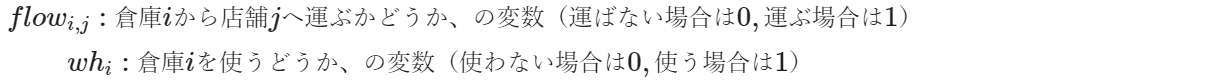

【目的関数】
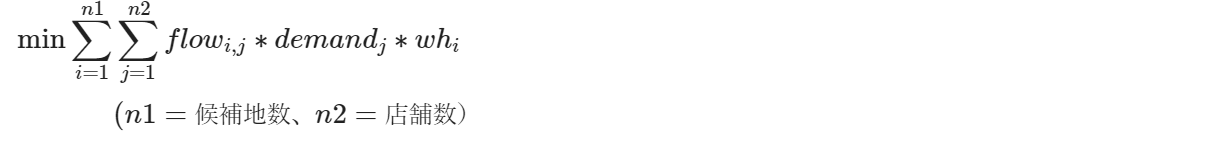

【制約条件】
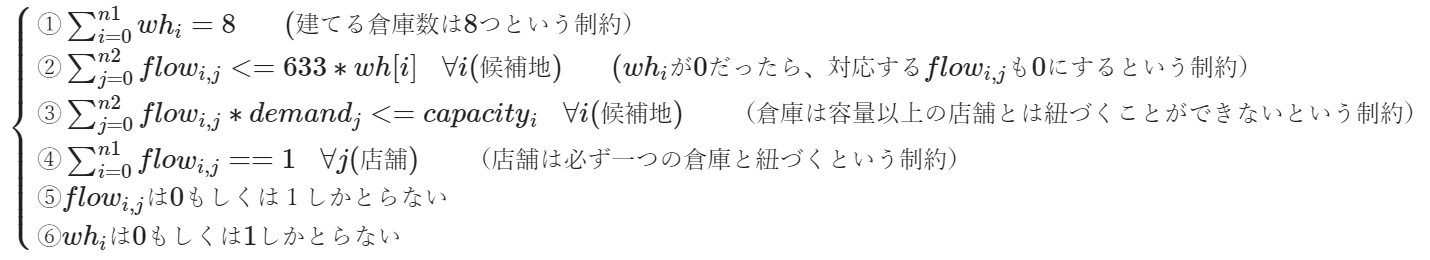

## CVXPYでの解法

In [9]:
import cvxpy as cp
import numpy as np

In [10]:
# 建てる倉庫の数を定義。倉庫を10箇所に立てたい場合は、ここを10に変更すれば１０箇所の最適配置を算出する。
num_warehouse = 8

# 倉庫候補地と店舗数
i = len(df_candidate)
j = len(df_store)

In [11]:
# flow変数を定義。同時に上記の⑤制約も追加している。
var_flow = cp.Variable((i, j), boolean=True)

In [12]:
# wh変数を定義。同時に上記の⑥の制約も追加している。
var_wh = cp.Variable(i, boolean=True)

In [13]:
var_flow.shape

(25, 252)

In [14]:
var_wh.shape

(25,)

In [15]:
%%time
# 目的関数を定義。リスト内表記で分かりづらいが、上記の目的関数を表現していること確認してください。
lst = [var_flow[i][j] * df_store.iloc[j]["demand"] * dic_dist[(i,j)] for i in df_candidate.index for j in df_store.index]

CPU times: user 2.84 s, sys: 36.9 ms, total: 2.88 s
Wall time: 2.9 s


In [16]:
lst

[Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, ZERO, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE, NONNEGATIVE, ()),
 Expression(AFFINE,

In [17]:
len(lst)

6300

In [18]:
%%time
# 目的関数の定義
objective = cp.Minimize(cp.sum(lst))

CPU times: user 507 ms, sys: 123 ms, total: 630 ms
Wall time: 634 ms


In [19]:
# 制約条件①を定義
constraints = [sum(var_wh) == num_warehouse]

In [20]:
# 制約条件②、③を定義。
for i in df_candidate.index:
    constraints  += [sum(var_flow[i]) <= 633 * var_wh[i]]
    constraints  += [var_flow[i] @ df_store["demand"] <= df_candidate.iloc[i].capacity * 4]

In [21]:
# 制約条件④を定義。
for j in df_store.index:
    constraints += [sum(var_flow[:,j]) == 1]

In [22]:
print(constraints)

[Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CONSTANT, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NONNEGATIVE, ())), Inequality(Expression(AFFINE, NON

In [23]:
len(constraints)

303

In [24]:
%%time
# 問題の定義
prob = cp.Problem(objective, constraints)
print(prob)

minimize 0.0 + var0[0, 0:252][0] * 7884.0 * 1076.5969347197486 + var0[0, 0:252][1] * 6607.0 * 1667.4485144394916 + var0[0, 0:252][2] * 1743.0 * 1057.7350941931988 + var0[0, 0:252][3] * 1757.0 * 2105.0349316203615 + var0[0, 0:252][4] * 7192.0 * 933.2844172458263 + var0[0, 0:252][5] * 9626.0 * 226.8968371867838 + var0[0, 0:252][6] * 11452.0 * 552.1309030692809 + var0[0, 0:252][7] * 28062.0 * 1529.2799945464467 + var0[0, 0:252][8] * 452563.0 * 613.0075447282861 + var0[0, 0:252][9] * 45256.0 * 0.0 + var0[0, 0:252][10] * 1238.0 * 995.0559748533943 + var0[0, 0:252][11] * 238977.0 * 983.6511370646318 + var0[0, 0:252][12] * 193152.0 * 1186.3971134675783 + var0[0, 0:252][13] * 21538.0 * 754.9138335018124 + var0[0, 0:252][14] * 212264.0 * 1150.4993695328392 + var0[0, 0:252][15] * 6836.0 * 650.7330818289936 + var0[0, 0:252][16] * 51369.0 * 184.1100098181028 + var0[0, 0:252][17] * 41831.0 * 337.6579158789275 + var0[0, 0:252][18] * 310183.0 * 1376.1292315557866 + var0[0, 0:252][19] * 78391.0 * 1093

In [25]:
%%time
# 解く
prob.solve()  # Returns the optimal value.
print("status:", prob.status)

status: optimal
CPU times: user 12min 14s, sys: 4.85 s, total: 12min 19s
Wall time: 12min 16s


In [26]:
# 結果の出力
ans_candidate = []
for i in df_candidate.index:
    if var_wh[i].value == 1:
        print("倉庫場所：{0}".format(df_candidate.iloc[i].city))
    ans_candidate.append(var_wh[i].value)
df_candidate["answer"] = ans_candidate
print("総km*需要(人) = {0}".format(prob.objective.value))

倉庫場所：福岡県志免町
倉庫場所：宮城県名取市
倉庫場所：岡山県笠岡市
倉庫場所：奈良県上牧町
倉庫場所：青森県中泊町
倉庫場所：長野県山ノ内町
倉庫場所：東京都台東区
倉庫場所：愛知県西尾市
総km*需要(人) = 1535457197.6916726


## foliumを使って地図上に結果を可視化しよう
https://python-visualization.github.io/folium/

In [27]:
import folium # conda install -c conda-forge folium
# まずはMapオブジェクトを生成します。初期の緯度経度位置、縮尺を引数として渡しています。
folium_map = folium.Map(location=[43, 138], zoom_start=5.0)

# clist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']

# ここでは倉庫をMarkerとしてMapオブジェクトに登録しています。
for k,v in df_candidate.iterrows():
    if var_wh[k].value == 1:
        # Markerに緯度経度を引数として渡し、add_toを使ってMapオブジェクトに追加しています。
        folium.Marker(location=[v.lat, v.lng]).add_to(folium_map)
        
# # ここでは店舗をCircleMarkerとしてMapオブジェクトに登録しています。同じ倉庫に紐づく店舗は同じ色にしています。
# for i, k in enumerate(df_candidate[df_candidate.answer == 1].index):
#     for v in var_flow[k]:
#         if v.value() == 1:
#             id_store = int(v.name.split("_")[-1])
#             # CircleMarkerの大きさ（radius）を需要に応じて変更するとより分かりやすい可視化になります。ここでは一律5にしています。
#             folium.CircleMarker(location=[df_store.iloc[id_store].lat, df_store.iloc[id_store].lng],
#                                 color=clist[i], 
#                                 radius=5, 
#                                 fill=True
#                                ).add_to(folium_map)
    
# 地図表示
folium_map

In [28]:
folium_map.save('./out/folium_map_cvxpy.html')